# AVIATION SAFETY NETWORK - DATA TRANSFORM - V2

En este notebook continuamos con la transformacion del dataset. En particular, realizamos imputacion de datos para algunas columnas.

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('../../data/transform/asn_final_v1.csv')
data.shape

(20709, 20)

In [3]:
data.columns

Index(['fecha', 'hora', 'operator', 'total_personas', 'cant_pasajeros',
       'cant_tripulantes', 'total_fallecidos', 'pasajeros_fallecidos',
       'tripulantes_fallecidos', 'pais_accidente', 'estado_accidente',
       'pais_salida', 'estado_salida', 'pais_destino', 'estado_destino',
       'primer_vuelo', 'aircraft_damage', 'razon', 'fase', 'narrative'],
      dtype='object')

## IMPUTACION DE DATOS FALTANTES

In [4]:
data.isnull().sum()

fecha                         0
hora                      12169
operator                    634
total_personas             4688
cant_pasajeros             6180
cant_tripulantes           6255
total_fallecidos           2213
pasajeros_fallecidos       3171
tripulantes_fallecidos     3165
pais_accidente              435
estado_accidente            775
pais_salida                5964
estado_salida              7395
pais_destino               5772
estado_destino             7231
primer_vuelo               4772
aircraft_damage            1077
razon                      2842
fase                         24
narrative                    73
dtype: int64

### TOTAL PASAJEROS | TOTAL FALLECIDOS | ETC.

Para los datos faltantes asumimos que la cantidad de personas fallecidas es igual al numero de tripulantes y pasajeros en el avion, y viceversa.

- Imputamos los datos faltantes en cant_pasajeros como igual al pasajeros_fallecidos
- Imputamos los datos faltantes en cant_tripulantes como igual al tripulantes_fallecidos
- Imputamos los datos faltantes en total_personas como igual al total_fallecidos

Y viceversa, esto es, pasajeros_fallecidos faltantes por cant_pasajeros, etc., etc.

In [5]:
columnas_1 = ['cant_pasajeros', 'cant_tripulantes', 'total_personas']
columnas_2 = ['pasajeros_fallecidos', 'tripulantes_fallecidos', 'total_fallecidos']

for k in range(len(columnas_1)):
    
    indice_1 = data[columnas_1[k]].isnull()
    indice_2 = data[columnas_2[k]].isnull()
    
    data.loc[indice_1, columnas_1[k]] = data.loc[indice_1, columnas_2[k]]
    data.loc[indice_2, columnas_2[k]] = data.loc[indice_2, columnas_1[k]]

Tenemos dos opciones frente a los datos faltantes:
1. Eliminar dichos datos.
2. Imputar los valores.

Dado que existe una relacion entre dichas columnas y sus respectivos totales, a saber: "total_personas" y "total_fallecidos", vamos a imputar.

Recordemos que: $total = pasajeros + tripulantes$. Por lo que $ tripulantes = total - total * proporcionPasajeros$

Para saber si calculamos la proporcion por la media o la mediana, veamos sus distribuciones.

Aunque sabemos que segun la ley de grandes numeros. Para n grandes, la distribucion de la proporcion se asemeja a una distribucion normal.

<Axes: >

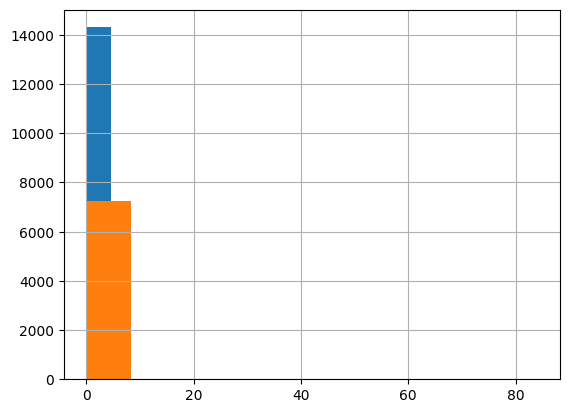

In [6]:
x = (data.cant_pasajeros / data.total_personas).replace([np.inf, -np.inf], np.nan)
y = (data.pasajeros_fallecidos / data.total_fallecidos).replace([np.inf, -np.inf], np.nan)

x.hist()
y.hist()

Su distribucion no sigue ningun patron simetrico, por lo que tomaremos la mediana

In [7]:
# Calculamos la mediana de la proporcion para "cant_pasajeros" y "pasajeros_fallecidos"
proporcion_cant_pasajeros = x.median(skipna=True)
proporcion_pasajeros_fallecidos = y.median(skipna=True)
proporcion_cant_pasajeros, proporcion_pasajeros_fallecidos

(0.5, 0.5)

In [8]:
# Imputamos los datos faltantes

# cant_pasajeros/pasajeros_fallecidos = proporcion * total
indice = data.cant_pasajeros.isnull()
data.loc[indice, 'cant_pasajeros'] = proporcion_cant_pasajeros * data.loc[indice, 'total_personas']
# cant_tripulantes = total - cant_pasajeros
data.loc[indice, 'cant_tripulantes'] = data.loc[indice, 'total_personas'] - data.loc[indice, 'cant_pasajeros']

# Del mismo modo, pero para las columnas de fallecidos

# cant_pasajeros/pasajeros_fallecidos = proporcion * total
indice = data.pasajeros_fallecidos.isnull()
data.loc[indice, 'pasajeros_fallecidos'] = proporcion_pasajeros_fallecidos * data.loc[indice, 'total_fallecidos']
# cant_tripulantes = total - cant_pasajeros
data.loc[indice, 'tripulantes_fallecidos'] = data.loc[indice, 'total_fallecidos'] - data.loc[indice, 'pasajeros_fallecidos']

- Para los datos faltantes en total_personas, imputamos como la suma de cant_pasajeros + cant_tripulantes.

- Para los datos faltantes en total_fallecidos, imputamos como la suma de pasajeros_fallecidos + tripulantes_fallecidos.

In [9]:
indice_1 = data['total_fallecidos'].isnull()
data.loc[indice_1, 'total_fallecidos'] = data.loc[indice_1, 'pasajeros_fallecidos'] + data.loc[indice_1, 'tripulantes_fallecidos']

indice_2 = data['total_personas'].isnull()
data.loc[indice_2, 'total_personas'] = data.loc[indice_2, 'cant_pasajeros'] + data.loc[indice_2, 'cant_tripulantes']

Veamos como es el resultado final del dataset con respecto a los nulos.

Naturalmente, van a quedar, ya que la operacion entre un numero y un valor faltantes es otro valor faltante.

In [10]:
data.isnull().sum()

fecha                         0
hora                      12169
operator                    634
total_personas             2204
cant_pasajeros             2203
cant_tripulantes           2204
total_fallecidos           2204
pasajeros_fallecidos       2203
tripulantes_fallecidos     2204
pais_accidente              435
estado_accidente            775
pais_salida                5964
estado_salida              7395
pais_destino               5772
estado_destino             7231
primer_vuelo               4772
aircraft_damage            1077
razon                      2842
fase                         24
narrative                    73
dtype: int64

Convertimos las valores de las columnas a valores enteros.

In [11]:
def auxiliar(v):
    try:
        return int(v)
    except:
        return np.nan

columnas_3 = columnas_1 + columnas_2

for c in columnas_3:
    data[c] = data[c].apply(lambda v:auxiliar(v))

<hr>

Por ultimo, eliminamos duplicados.

Consideramos duplicados aquellos accidentes que ocurrieron en una misma fecha y en un mismo pais.

In [12]:
print('antes:', data.shape[0])
data = data.drop_duplicates(subset=['fecha', 'pais_accidente'])
print('despues:', data.shape[0])

antes: 20709
despues: 19291


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19291 entries, 0 to 20708
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   fecha                   19291 non-null  object 
 1   hora                    8064 non-null   object 
 2   operator                18690 non-null  object 
 3   total_personas          17448 non-null  float64
 4   cant_pasajeros          17449 non-null  float64
 5   cant_tripulantes        17448 non-null  float64
 6   total_fallecidos        17448 non-null  float64
 7   pasajeros_fallecidos    17449 non-null  float64
 8   tripulantes_fallecidos  17448 non-null  float64
 9   pais_accidente          18904 non-null  object 
 10  estado_accidente        18602 non-null  object 
 11  pais_salida             13811 non-null  object 
 12  estado_salida           12807 non-null  object 
 13  pais_destino            14020 non-null  object 
 14  estado_destino          12986 non-null  obj

### PAIS | ESTADO ACCIDENTE

In [14]:
data.pais_accidente = data.pais_accidente.str.replace('[^a-zA-Z\s]', '', regex=True)

In [15]:
data.to_csv('../../data/transform/asn_final_v2.csv', header=True, index=False, sep=',', mode='w')